## Case TON - Análise técnica dos dados
##### Fernando Fincatti
---

## Imports
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime
from utils import*
from sklearn.cluster import KMeans
from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster

In [2]:
df_cases = pd.read_csv("cases.csv") #importa arquivo cases
df_creds = pd.read_csv("creds.csv") #importa arquivo creds

In [3]:
df_creds.head(2)

,Unnamed: 0,cred_date,shipping_address_city,shipping_address_state,max_machine,accountid
0,0,2020-04-18,Feira de Santana,BA,T1,NaN
1,1,2020-10-16,Bacuri,MA,T1,NaN


In [4]:
df_creds.columns

Index(['Unnamed: 0', 'cred_date', 'shipping_address_city',
       'shipping_address_state', 'max_machine', 'accountid'],
      dtype='object')

In [5]:
df_cases.head(2)

,Unnamed: 0,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_cases.columns

Index(['Unnamed: 0', 'accountid', 'date_ref', 'channelid', 'waitingtime',
       'missed', 'pesquisa_de_satisfa_o__c', 'assunto', 'Id'],
      dtype='object')

In [7]:
#filtra somente para os chamados que possuem data registrada
df_cases = df_cases.dropna(subset=['date_ref'])
df_creds = df_creds.dropna(subset=['cred_date']) 

In [8]:
#transforma dados para datetime
df_cases["date_ref"] = df_cases['date_ref'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")) 

#cria coluna ano, mês e dia
df_cases["mes"] = df_cases['date_ref'].apply(lambda x: x.month) 
df_cases["dia"] = df_cases['date_ref'].apply(lambda x: x.day) 

In [9]:
#transforma dados para datetime
df_creds["cred_date"] = df_creds['cred_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")) 

#cria coluna ano, mês e dia
df_creds["mes"] = df_creds['cred_date'].apply(lambda x: x.month) 
df_creds["dia"] = df_creds['cred_date'].apply(lambda x: x.day) 

## Questão 1.
---

In [10]:
df_cases_q1 = df_cases.copy()

In [11]:
#coluna que serve apenas para contagem de chamados
df_cases_q1["count"] = 1

#tabela com a somatória de chamados para todo o período
table_q1 = df_cases_q1[["mes", "count"]].groupby(['mes']).sum()

#tabela com a somatória de chamados para o período antes da implementação
table_q1_tendencia = df_cases_q1.loc[df_cases_q1["mes"] < 8][["mes", "count"]].groupby(['mes']).count()

In [12]:
z = np.polyfit(table_q1_tendencia.index.tolist(), table_q1_tendencia["count"].tolist(), 2)
function = np.poly1d(z)

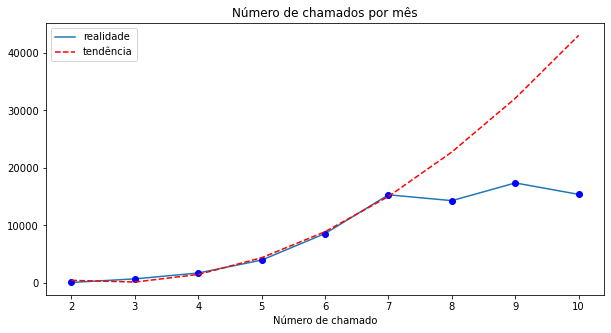

In [13]:
plt.figure(figsize=(10,5))
plt.title("Número de chamados por mês")
plt.xlabel("Número de chamado")
plt.plot(table_q1, label="realidade") #plota curva dos dados
plt.plot(table_q1, 'bo') #cria pontos
plt.plot(table_q1.index.tolist(), function(table_q1.index.tolist()),"r--", label="tendência") #realiza previsão
plt.legend()
plt.show()

Com base no gráfco acima, podemos ver que o número de chamados vinha aumentando exponencialmente, após a implementação no dia 
primeiro de agosto, o volume de chamados caiu drasticamente, quebrando completamente a tendência de crescimento do gráfico. Portanto podemos concluir que a implementação foi um sucesso!

## Questão 2.
---

In [14]:
#filtra somente os cliente possíveis de serem indentificados
df_cases_q2 = df_cases.dropna(subset=["accountid"]) 
df_creds_q2 = df_creds.dropna(subset=["accountid"])

In [15]:
#junta os dois datasets, somente aqueles que estão credenciados
df_merged = pd.merge(df_cases_q2, df_creds_q2, on='accountid', how='inner')

In [16]:
#calcula distância em dias do dia de credenciamento
df_merged["time_distance"] = df_merged.apply(lambda x: (x["cred_date"] - x["date_ref"]).days, axis=1)

In [17]:
#coluna de contagem
df_merged["count"] = 1

In [18]:
lista_ids = df_merged.accountid.unique().tolist() #pega todos os id unicos
lista_media_mes_seguinte = []
lista_media_meses_anteriores = []
counter = 0 #progesso
for id_ in lista_ids:
    counter += 1
    
    response = get_5months_before(id_, df_merged) #pega chamados
    
    #armazena as médias de chamadas do mes seguinte ao cred para todos os clientes
    lista_media_mes_seguinte.append(response[1])
    
    #armazena as médias de chamadas dos meses ateriores ao cred para todos os clientes
    lista_media_meses_anteriores.append(response[0])   
    
    progresso = round(counter*100/len(lista_ids) , 2)
    print("{:,} | {:,} > {}%".format(counter, len(lista_ids), progresso), end = "\r")

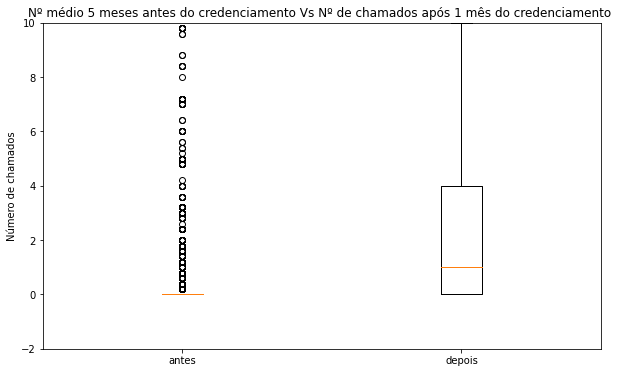

In [19]:
plt.figure(figsize=(10,6))
plt.boxplot([lista_media_meses_anteriores, lista_media_mes_seguinte], labels=['antes', 'depois'])
plt.title("Nº médio 5 meses antes do credenciamento Vs Nº de chamados após 1 mês do credenciamento ")
plt.ylim(-2, 10)
plt.ylabel("Número de chamados")
plt.show()

Como é possível observar no boxplot acima, a concetração de número médios de chamados 5 meses antes do credenciamento é muito menor quando comparado ao mês seguinte ao mesmo. Portanto, podemos concluir que o número de chamados logo após a data do credenciamento do aumenta consideravelmente!

In [20]:
md_antes = sum(lista_media_meses_anteriores) / len(lista_media_meses_anteriores)
md_depois= sum(lista_media_mes_seguinte) / len(lista_media_mes_seguinte)

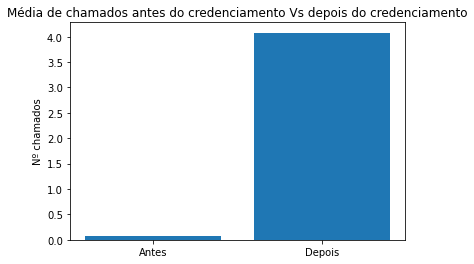

Após o credenciamento, o aumento no número médio de chamados é de: 54.74 vezes


In [21]:
plt.title("Média de chamados antes do credenciamento Vs depois do credenciamento")
plt.bar(['Antes', 'Depois'], [md_antes, md_depois])
plt.ylabel("Nº chamados")
plt.show()

print("Após o credenciamento, o aumento no número médio de chamados é de: {0} vezes".format(round(md_depois/md_antes, 2)))

Como o gráfico acima, podemos reforçar a nossa conclusão, uma vez que a média de chamados aumentou 54.74 vezes logo após o credenciamento quando comparado aos 5 meses anteriores

## Questão 3.
---

In [22]:
df_cluster = pd.merge(df_cases, df_creds, on='accountid', how='outer')

In [23]:
#filtra as colunas desejadas e remove todas as colunas que são NaN, ou seja, que não é possível fazer a clusterização
df_cluster = df_cluster[['channelid','waitingtime','missed','pesquisa_de_satisfa_o__c', 'assunto', 'date_ref', 'cred_date']].dropna(subset=['pesquisa_de_satisfa_o__c'])

In [24]:
#cria coluna binária, 1 se o cliente foi cred recentemente e 0 caso contrário
df_cluster["cred_recente"] = df_cluster.apply(lambda x: recentemente_credenciado(x['date_ref'],x['cred_date']), axis=1)

In [25]:
#transforma avaliações boas em 1, neutras em 0 e ruins em -1
df_cluster['avaliacao_to_integer'] = df_cluster['pesquisa_de_satisfa_o__c'].apply(lambda x: transforma_avaliação(x))

In [26]:
df_cluster_test = df_cluster.drop(["pesquisa_de_satisfa_o__c", "assunto", "date_ref", "cred_date"], axis='columns')

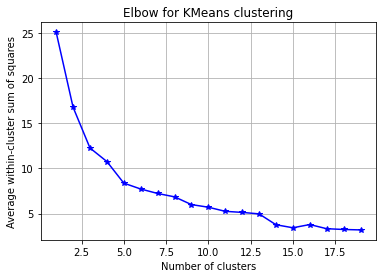

In [27]:
#descobrindo o número de clsuters necessários
cdata = df_cluster_test
K = range(1, 20)
KM = (sk_cluster.KMeans(n_clusters=k).fit(cdata) for k in K)
centroids = (k.cluster_centers_ for k in KM)

D_k = (sci_distance.cdist(cdata, cent, 'euclidean') for cent in centroids)
dist = (np.min(D, axis=1) for D in D_k)
avgWithinSS = [sum(d) / cdata.shape[0] for d in dist]
plt.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

Com base no gráfico acima, podemos concluir que o número ideal de clusters para se utilizar é aproximadamente 5.

Fonte: https://docs.microsoft.com/pt-br/sql/machine-learning/tutorials/python-clustering-model-build?view=sql-server-ver15

In [28]:
n_clusters = 5

means_cluster = sk_cluster.KMeans(n_clusters=n_clusters, random_state=111)
columns = ['channelid','waitingtime','missed','avaliacao_to_integer', 'cred_recente']
est = means_cluster.fit(df_cluster[columns])
clusters = est.labels_
df_cluster['cluster'] = clusters

# Print some data about the clusters:

# For each cluster, count the members.
for c in range(n_clusters):
    cluster_members=df_cluster[df_cluster['cluster'] == c][:]
    print('Cluster{}(n={}):'.format(c, len(cluster_members)))
    print('-'* 17)
print(df_cluster.groupby(['cluster']).mean())

Cluster0(n=45185):
-----------------
Cluster1(n=195):
-----------------
Cluster2(n=521):
-----------------
Cluster3(n=55):
-----------------
Cluster4(n=1891):
-----------------
         channelid  waitingtime  cred_recente  avaliacao_to_integer
cluster                                                            
0              2.0    12.538519      0.805776              0.101339
1              2.0   814.425641      0.887179              0.010256
2              2.0   339.491363      0.861804              0.157390
3              2.0  1488.327273      0.727273              0.145455
4              2.0   110.756214      0.793231              0.043363


In [29]:
cluster = df_cluster.cluster.unique().tolist()

In [30]:
for cl in cluster:
    print("CLUSTER -> {0}".format(cl))
    counts = df_cluster.loc[df_cluster['cluster'] == cl]['avaliacao_to_integer'].value_counts(True)

    if( len(counts) == 3):
        pos = df_cluster.loc[df_cluster['cluster'] == cl]['avaliacao_to_integer'].value_counts(True)[1] * 1
        neg = df_cluster.loc[df_cluster['cluster'] == cl]['avaliacao_to_integer'].value_counts(True)[1] * (-1)
        print("Pontuação: {0}".format(round(pos-neg, 2)))
   
    elif(len(counts) == 2):
        pos = df_cluster.loc[df_cluster['cluster'] == cl]['avaliacao_to_integer'].value_counts(True)[1] * 1
        print("Pontuação: {0}".format(round(pos, 2)))
    else:
        print("Pontuação: 0")

        
    print()

CLUSTER -> 0
Pontuação: 0.23

CLUSTER -> 2
Pontuação: 0.36

CLUSTER -> 4
Pontuação: 0.18

CLUSTER -> 3
Pontuação: 0.15

CLUSTER -> 1
Pontuação: 0.05



Para realizar a análise foi utilizado o algorítmo k-means, segmentando o dataset em 5 diferentes grupos. Foi estabelecido um sistema de pontuação, sendo avaliações neutras = 0, positivas = 1 e negativas = -1. Dessa forma, a pontuação de cada um dos clusters foi calculada da seguinte forma:

(Nº de av. positivas)*1 + (Nº de av. neutras)*0 + (Nº de av. negativas)*(-1)

É possível observar que o cluster 1 apresenta a menor pontuação, portanto possue a pior combinação de avaliações. Dessa forma, o CLUSTER 1 seria um bom ponto de partida para melhorar a avaliação dos atendimentos.

Inspiração: algoritmo de Needleman-Wunsch.

Fonte: https://pt.wikipedia.org/wiki/Algoritmo_Needleman-Wunsch#:~:text=O%20algoritmo%20Needleman%E2%80%93Wunsch%20tem,seq%C3%BC%C3%AAncias%20de%20prote%C3%ADnas%20ou%20nucleot%C3%ADdeos.

## Questão 4
---

In [31]:
df_q4 = df_cluster.copy()

In [32]:
df_q4.head()

,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,date_ref,cred_date,cred_recente,avaliacao_to_integer,cluster
103,2.0,4.0,False,Enviado,Pedido:Confirmação do pedido:,2020-06-03,2020-06-05,0,0,0
104,2.0,4.0,False,Enviado,Pedido:Confirmação do pedido:,2020-06-03,2020-06-05,0,0,0
105,2.0,4.0,False,Enviado,Pedido:Confirmação do pedido:,2020-06-03,2020-06-05,0,0,0
106,2.0,4.0,False,Enviado,Pedido:Confirmação do pedido:,2020-06-03,2020-06-05,0,0,0
107,2.0,4.0,False,Enviado,Pedido:Confirmação do pedido:,2020-06-03,2020-06-05,0,0,0


In [33]:
df_q4["mes"] = df_q4["date_ref"].apply(lambda x: x.month)

In [34]:
ultimo_mes = df_q4["mes"].max() #pega o últmo mês
df_q4_3meses = df_q4.loc[df_q4["mes"] > ultimo_mes - 3] #filtra somente os ultimos 3 meses
df_q4_3meses["week_number"] = df_q4_3meses["date_ref"].apply(lambda x: x.isocalendar()[1]) #define o número da semana em relação ao ano

<ipython-input-34-be79c912ecad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q4_3meses["week_number"] = df_q4_3meses["date_ref"].apply(lambda x: x.isocalendar()[1]) #define o número da semana em relação ao ano


In [35]:
#cria coluna para somar
df_q4_3meses["counter"] = 1

<ipython-input-35-0bd04389cdc6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q4_3meses["counter"] = 1


In [36]:
#soma o número de chamados por semana por cluster dos últimos 3 meses
query = df_q4_3meses[["week_number", "cluster", "counter"]].groupby(["week_number", "cluster"]).sum()

In [37]:
query

counter
week_number cluster         
14          0            470
            4              1
15          0           1012
            4             20
16          0           1227
            2              1
            4             12
17          0           1500
            4              8
18          0           1685
            1              3
            2             10
            4             18
19          0           2640
            1              3
            2              8
            4             80
20          0           3346
            1              2
            2             17
            3              6
            4             73
21          0           2965
            1             59
            2             38
            3             10
            4            165
22          0           3095
            1             32
            2             68
            3              3
            4             73
23          0           4072
            1             46
            2             85
            3             20
            4            214
24          0           4163
            1             15
            2             92
            3              7
            4            274
25          0           5662
            1             17
            2             88
            3              9
            4            319
26          0           7766
            1              9
            2            101
            4            473
27          0           3073
            1              9
            2             13
            4            145

## Questão 5
---

1° KPI: volume de chamados por assunto, para que dessa forma sejam indentificados o principais problemas enfrentados pelos clientes;

2º KPI: número de atendimentos perdidos;

3º KPI: tempo médio de resposta;

4º KPI: volume de chamados por canal de contato, para que dessa forma seja possível direcionar o atendimento para canais específicos.